**Course website**: http://lagex.github.io/geofisica2

**Note**: This notebook is part of the course "Geofísica 2" of Geology program of the 
[Universidade do Estado do Rio de Janeiro](http://www.uerj.br/). 
All content can be freely used and adapted under the terms of the 
[Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)

Esse documento que você está usando é um [IPython notebook](http://ipython.org/notebook.html). É um documento interativo que mistura texto (como esse), código (como abaixo), e o resultado de executar o código (que pode ser números, texto, figuras, videos, etc).

# Prática 6 - Sísmica de reflexão: CMP, NMO e empilhamento

Nessa prática, vamos simular a aquisição de uma seção Common Mid Point (CMP). Vamos ver como utilizar a correção de Normal Moveout (NMO) para determinar a velocidade. Também vamos ver como o empilhamento melhora a razão sinal-ruído dos nossos dados.

Para isso, vamos utilizar as simulações de ondas da biblioteca [Fatiando a Terra](http://www.fatiando.org). Essas simulações utilizam o [método de diferenças finitas](http://en.wikipedia.org/wiki/Finite_difference_method) para calcular soluções da equação da onda.

As tarefas abaixo acompanham as questões que vocês devem responder. Usem as simulações abaixo para te ajudar a responder as perguntas.

## Preparação

Rode a célula abaixo para carregar as componentes necessárias para fazer as simulações. Não se preocupe se aparecer um `:0: FutureWarning: IPython widgets are experimental and may change in the future.` abaixo. Isso é consequência de utilizar tecnologia de ponta.

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from IPython.html import widgets
from IPython import display
from fatiando import utils
from fatiando.seismic.wavefd import Ricker, ElasticSH
from fatiando.vis import mpl
import fatiando
from multiprocessing import Pool

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
print(fatiando.__version__)

0.3-224-gb6a56f8


## Simulação de um CMP para um modelo de duas camadas

In [41]:
shape = (150, 200)
spacing = 10
extent = [0, shape[1]*spacing, shape[0]*spacing, 0]
densidade = np.ones(shape)*1600
velocidade = np.ones(shape)*4000
l1 = shape[0]//3
densidade[l1:,:] = 1800
velocidade[l1:,:] = 5000
l2 = shape[0]//2
densidade[l2:,:] = 2000
velocidade[l2:,:] = 6000

In [56]:
def run_sim(fonte, its=800):    
    sim = ElasticSH(velocidade, densidade, spacing=spacing, taper=0.005, padding=45, verbose=False)
    sim.add_point_source((0, fonte), Ricker(5, 45, 2/45))
    sim.run(its)
    return sim

In [57]:
fontes = list(reversed(range(55, shape[1]//2 - 5, 5)))
recep = [shape[1] - s for s in fontes]
offsets = [(r - f)*spacing for r, f in zip(recep, fontes)]
print("Utilizando {} fontes e {} receptores.".format(len(fontes), len(recep)))

Utilizando 8 fontes e 8 receptores.


In [60]:
sim = run_sim(fontes[0])

In [76]:
sim.animate(20, embed=True, dpi=50, fps=5, cutoff=0.0002, cmap='Greys')

In [62]:
pool = Pool()
sims = pool.map(run_sim, fontes)
pool.close()

In [63]:
dt = sims[0].dt
times = np.linspace(0, dt*sims[0].size, sims[0].size)

In [64]:
def pega_cmp(sims):
    u"Essa função extrai o CMP das simulações que fizemos."
    CMP = np.empty((sims[0].size, len(recep)))
    for i, sim in enumerate(sims):
        CMP[:, i] = sim[:, 0, recep[i]]
    return CMP

In [65]:
CMP = pega_cmp(sims)

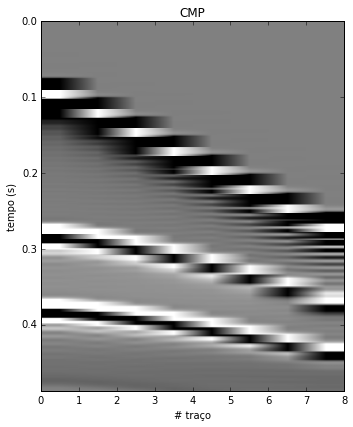

In [66]:
plt.figure(figsize=(6, 6))
plt.title("CMP")
mpl.seismic_image(CMP, dt=sims[0].dt, vmin=-0.00001, vmax=0.00001, aspect=20)
plt.xlabel(u'# traço')
plt.ylabel('tempo (s)')
plt.tight_layout()

## Correção de NMO e  análise de  velocidades

In [67]:
def nmo_correction(CMP, times, offsets, v):
    nmo = np.zeros_like(CMP)
    for i, t0 in enumerate(times):
        for j, o in enumerate(offsets):
            t = np.sqrt(t0**2 + o**2/v**2)
            k = t//dt
            if k < times.size - 1:
                # Linear interpolation of the amplitude
                y0, y1 = CMP[k, j], CMP[k + 1, j]
                x0, x1 = times[k], times[k + 1]
                nmo[i, j] = y0 + (y1 - y0)*(t - x0)/(x1 - x0)
    return nmo

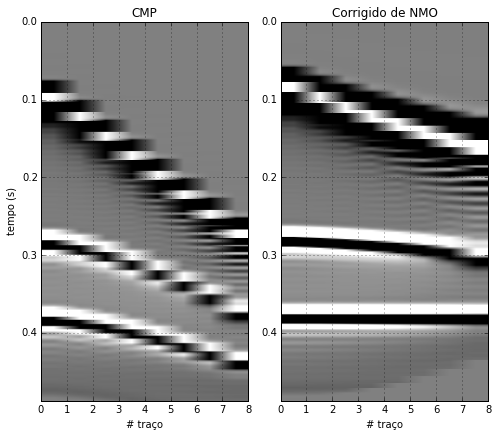

In [68]:
def nmo_analise(v):
    nmo = nmo_correction(CMP, times, offsets, v)
    plt.figure(figsize=(7, 6))
    plt.subplot(121)
    plt.title('CMP')
    gain = 0.00001
    mpl.seismic_image(CMP, dt=sims[0].dt, vmin=-gain, vmax=gain, aspect=30)
    plt.grid()
    plt.xlabel(u'# traço')
    plt.ylabel('tempo (s)')
    plt.subplot(122)
    plt.title('Corrigido de NMO')
    gain = 0.00001
    mpl.seismic_image(nmo, dt=sims[0].dt, vmin=-gain, vmax=gain, aspect=30)
    plt.grid()
    plt.xlabel(u'# traço')
    plt.tight_layout()
widgets.interactive(nmo_analise, v=widgets.FloatSliderWidget(min=2000, max=6000, step=100, value=2000))

## Empilhamento

In [69]:
ruido = 0.00003
CMP_ruido = CMP + np.random.uniform(-ruido, ruido, CMP.shape)

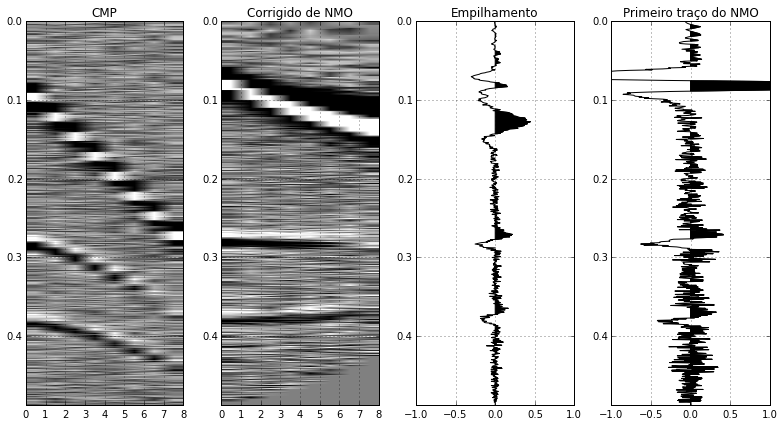

In [73]:
def nmo_empilhamento(v):
    nmo = nmo_correction(CMP_ruido, times, offsets, v)
    plt.figure(figsize=(11, 6))
    plt.subplot(141)
    plt.title('CMP')
    gain = 0.00005
    mpl.seismic_image(CMP_ruido, dt=sims[0].dt, vmin=-gain, vmax=gain, aspect=40)
    plt.grid(True)
    plt.ylabel('tempo (s)')
    plt.subplot(142)
    plt.title('Corrigido de NMO')
    gain = 0.00005
    mpl.seismic_image(nmo, dt=sims[0].dt, vmin=-gain, vmax=gain, aspect=40)
    plt.grid(True)
    plt.subplot(143)
    plt.title('Empilhamento')
    stack = np.atleast_2d(nmo.sum(1)).T
    mpl.seismic_wiggle(stack, dt=dt, scale=500)
    plt.xlim(-1, 1)
    plt.grid()
    plt.subplot(144)
    plt.title(u'Primeiro traço do NMO')
    mpl.seismic_wiggle(np.atleast_2d(nmo[:, 0]).T, dt=dt, scale=5000)
    plt.xlim(-1, 1)
    plt.grid()
    plt.tight_layout()
    return nmo
w = widgets.interactive(nmo_empilhamento, v=widgets.FloatSliderWidget(min=2000, max=6000, step=100, value=2000))
w